In [1]:
import sys

sys.path.insert(1, '../')

#from feature_extraction.variational_autoencoder.vae_feature_extractor import Vae_Feature_Extractor
from feature_extraction.variational_autoencoder.vae_feature_extractor_torch import Vae_Feature_Extractor
from feature_prediction.long_short_term_memory.lstm_prediction_model import Lstm_prediction_model
from feature_prediction.deep_transformer.deep_transformer import Transformer_prediction_model
from arbitrage_free_ivs.nsa_ivs_dnn import NSA_IVS_DNN
#from arbitrage_free_ivs.nsa_ivs_dnn_torch import NSA_IVS_DNN
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper
from feature_prediction.plot.plot_helper_functions import plot_features_with_prediction

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
test_id = 13
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

# id = 12:
# sabr_parameters = np.array([0.2, 0.6, -0.6, 1., 0.1]) 
# noise = N(0,0.005)
# \alpha_i = 0.2 + 0.05 * np.sin(i/200) + noise, i=1,...600
# \beta_i = 0.6 + 0.15 * np.sin(i/200) + noise, i=1,...600

# id = 13:
# sabr_parameters = np.array([0.2, 0.6, -0.6, 1., 0.1]) 
# noise = N(0,0.005)
# \alpha_i = 0.4 + 0.2 * i/600 + noise, i=1,...600

iv_data = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')

In [3]:
call_data = np.genfromtxt(f"../data/test{test_id}_call_data_sabr.csv", delimiter=',').reshape((600, 12, 16)).astype('float32')

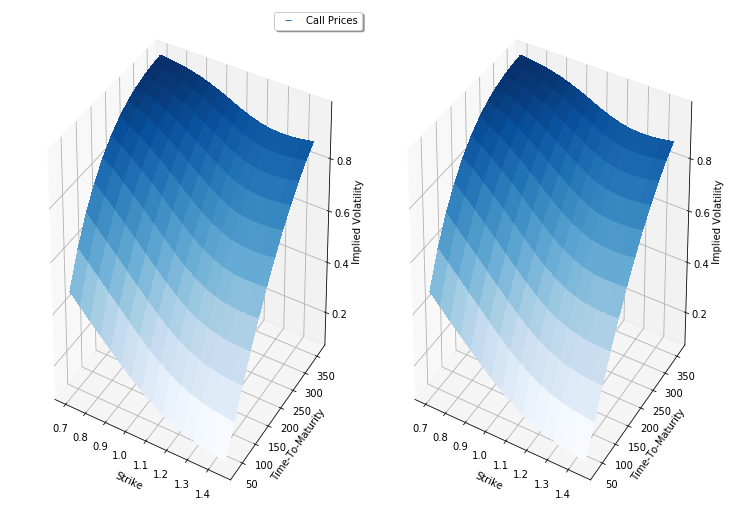

In [4]:
plot_data = {
    "iv_surface_1": call_data,
    "stikes_surface_1": strikes,
    "ttms_surface_1": ttms,
    "legend": ["Call Prices"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(30, 300))

In [5]:
feature_dim = 7

feature_extractor = Vae_Feature_Extractor(
    file_name = f"../data/test{test_id}_data_sabr.csv", 
    shape = (600, 12, 16, 1),
    params = {
        "feature_dim": feature_dim,
        "batch_size": 8,
        "beta": 0.02,
    }
)

In [ ]:
# train vae
history = feature_extractor.train(1000)
# save vae
feature_extractor.save_model(f"vae_{test_id}")

Epoch: 0 Reconstruction Loss: 78.43551376342774 KL Loss: 242.51818686688742 Total Loss: 320.9536814626058
Epoch: 1 Reconstruction Loss: 18.082829920450845 KL Loss: 0.4467291478474935 Total Loss: 18.52955909729004
Epoch: 2 Reconstruction Loss: 8.545739987691244 KL Loss: 0.3969753173828125 Total Loss: 8.942715276082357
Epoch: 3 Reconstruction Loss: 6.28563694636027 KL Loss: 0.3606695337931315 Total Loss: 6.646306489308675
Epoch: 4 Reconstruction Loss: 4.947951666514078 KL Loss: 0.3359318333943685 Total Loss: 5.2838834921518965
Epoch: 5 Reconstruction Loss: 4.066628786722819 KL Loss: 0.3178231122334798 Total Loss: 4.384451907475789
Epoch: 6 Reconstruction Loss: 3.1706301307678224 KL Loss: 0.30035280761718747 Total Loss: 3.470982936223348
Epoch: 7 Reconstruction Loss: 2.8925612862904866 KL Loss: 0.2881482599894206 Total Loss: 3.1807095432281494
Epoch: 8 Reconstruction Loss: 2.5980818923314413 KL Loss: 0.27795657348632813 Total Loss: 2.876038465499878
Epoch: 9 Reconstruction Loss: 1.9797354

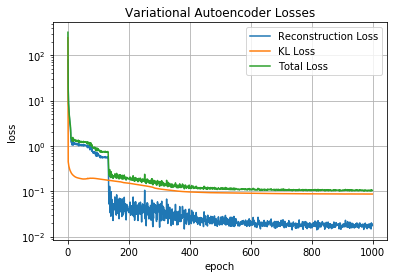

In [15]:
from matplotlib import pyplot as plt

plt.plot(history)
plt.title('Variational Autoencoder Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Reconstruction Loss','KL Loss', 'Total Loss'], loc='upper right')
plt.grid()
plt.yscale("log")
#plt.ylim(1e-7,1e5)

#plt.show()
plt.savefig("vae_losses.pdf")

In [6]:
# load vae
feature_extractor.load_model(f"vae_{test_id}")

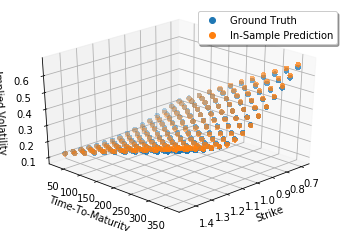

In [19]:
ind = 550

z = feature_extractor.autoencoder.encoder(torch.from_numpy(iv_data))
rec = feature_extractor.autoencoder.decoder(z).detach().numpy()

strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

plot_data = {
    "iv_grid_1": iv_data[ind:ind+1],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": rec[ind:ind+1],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth","In-Sample Prediction"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(30, 45))

Text(0.5, 0, 'Timestep')

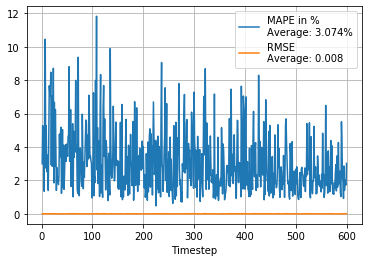

In [20]:
true_ivs = iv_data[:,:,:,0]
predicted_ivs = rec[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
#plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")

In [11]:
# save feature space data
data = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')
print("data shape:",data.shape)
feature_data = feature_extractor.produce_features(data)
print("feature data shape:",feature_data.shape)
feature_extractor.save_produced_features(f"latent_space_data/features_{test_id}")

data shape: (600, 12, 16, 1)
feature data shape: (600, 7)


In [7]:
# load data and create data set with features
feature_data = np.genfromtxt(f"latent_space_data/features_{test_id}_vae_model", delimiter=',').astype('float32')
print(feature_data.shape)

look_back = 150
num_data_points = feature_data.shape[0]
num_train_data_points = int(0.7*num_data_points)

transformer_model = Transformer_prediction_model(
    feature_data, 
    params={"look_back": look_back, "forecast_window": int(0.3*num_data_points)},
    decoder=feature_extractor.autoencoder.decoder,
    call_prices=call_data,
    strikes=strikes,
    ttms=ttms
)

(600, 7)
Data shape with extra features:  (600, 11)


In [8]:
# train the model
path = f"./models/deep_transformer/res{test_id}/"
best_model = transformer_model.transformer_no_dynamic_arbitrage(
    epochs=10, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu"
)
print(best_model)

KeyboardInterrupt: 

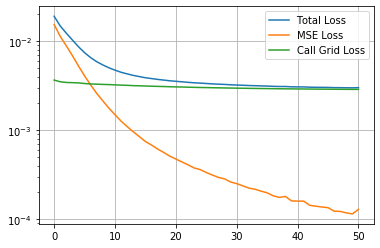

In [66]:
loss_file = f"./models/deep_transformer/res{test_id}/"+"train_loss.txt"

loss_vaules = np.genfromtxt(loss_file, delimiter=',')

plt.plot(loss_vaules[:,0])
plt.plot(loss_vaules[:,1])
plt.plot(loss_vaules[:,2])
plt.grid(True)
plt.yscale('log')
plt.legend(['Total Loss','MSE Loss','Call Grid Loss'], loc='upper right')

In [8]:
# make predictions
prediction_features, in_sample_errors = transformer_model.inference(path_to_save_model=f"./models/deep_transformer/res{test_id}/", best_model="best_train_NDA_0.pth")
print(prediction_features.shape)

(180, 7)


(180, 7)


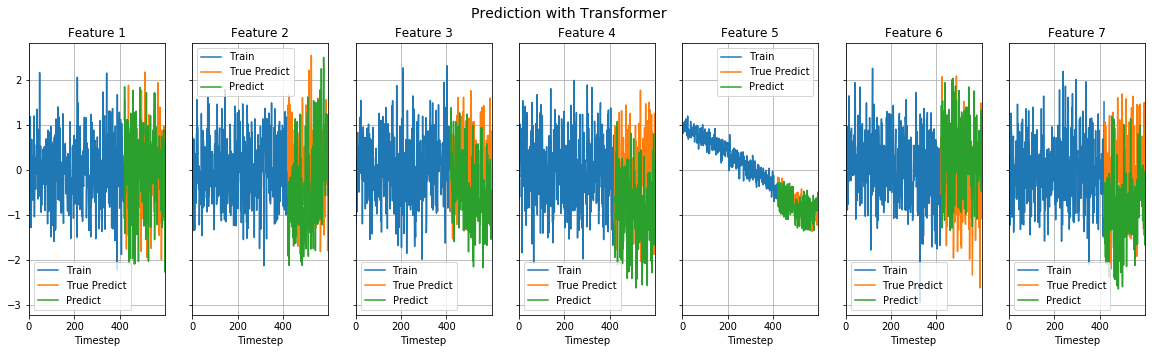

In [9]:
true_ = feature_data[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=220, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
print(boot_strap_errors.shape)
pred_vec = prediction_features+boot_strap_errors

fig = plot_features_with_prediction(
    data=feature_data[:num_train_data_points],
    prediction=pred_vec,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={
        "fig_title":"Prediction with Transformer",
        "share_y": True
    }
)

In [11]:
predicted_iv_grids = feature_extractor.create_iv_grids_from_features(pred_vec)
print(predicted_iv_grids.shape)

(180, 12, 16, 1)


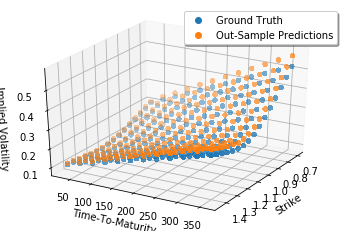

In [51]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": iv_data[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth", "Out-Sample Predictions"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 5, view_angle=(30, 30))

Text(0.5, 0, 'Timestep')

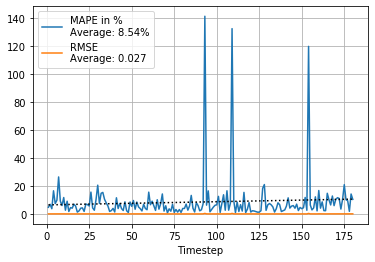

In [52]:
true_ivs = iv_data[600-180:,:,:,0]
predicted_ivs = predicted_iv_grids[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)


mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")

plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")

In [12]:
# create nsa_ivs_dnn
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

# same as data above but needs different shape
data_nsa_train = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').astype('float32')
nsa_ivs = NSA_IVS_DNN(data_nsa_train, [strikes, ttms], (3,30,30,30))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                5850      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 7,741
Trainable params: 7,741
Non-trainable params: 0
_________________________________________________________________


In [44]:
# train NSA DNN using training data
history = nsa_ivs.train(epochs=30)

# elu, one layer, 100 nodes -> 0.09
# elu, two layer, 30,30 nodes -> 0.05
# elu, three layer, 30,30,30 nodes -> 0.01
# relu, two layer, 100,50 nodes -> 0.02

# save NSA DNN
nsa_ivs.save_model(f"nsa_dnn_model{test_id}")

Epoch 1/30
600/600 [==============================] - 11s 18ms/step - total_loss: 1.4957 - reconstruction_loss: 1.4957 - nsa_C3: 0.0058 - nsa_C4: 1.8124e-12 - nsa_C5: 1.5329e-05 - nsa_C6: 3.2066e-13
Epoch 2/30
600/600 [==============================] - 10s 16ms/step - total_loss: 0.6238 - reconstruction_loss: 0.6238 - nsa_C3: 0.0069 - nsa_C4: 2.7621e-12 - nsa_C5: 2.3312e-05 - nsa_C6: 2.0152e-13
Epoch 3/30
600/600 [==============================] - 10s 16ms/step - total_loss: 0.3845 - reconstruction_loss: 0.3845 - nsa_C3: 0.0064 - nsa_C4: 2.7172e-12 - nsa_C5: 2.2784e-05 - nsa_C6: 1.9392e-13
Epoch 4/30
600/600 [==============================] - 10s 16ms/step - total_loss: 0.4904 - reconstruction_loss: 0.4904 - nsa_C3: 0.0061 - nsa_C4: 2.7445e-12 - nsa_C5: 2.2468e-05 - nsa_C6: 1.8844e-13
Epoch 5/30
600/600 [==============================] - 10s 16ms/step - total_loss: 0.3099 - reconstruction_loss: 0.3099 - nsa_C3: 0.0046 - nsa_C4: 2.5659e-12 - nsa_C5: 1.9537e-05 - nsa_C6: 1.8165e-13
Epoch

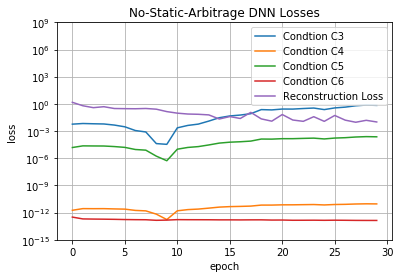

In [45]:
from matplotlib import pyplot as plt

plt.plot(history.history['nsa_C3'])
plt.plot(history.history['nsa_C4'])
plt.plot(history.history['nsa_C5'])
plt.plot(history.history['nsa_C6'])
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['total_loss'], ls=':', c='black')
plt.title('No-Static-Arbitrage DNN Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss', 'Total Loss'], loc='upper right')
plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss'], loc='upper right')

plt.grid()
plt.yscale("log")
plt.ylim(1e-15,1e9)

#plt.show()
plt.savefig("nsa_dnn_losses.pdf")

In [13]:
# load NSA DNN
nsa_ivs.load_model(f"nsa_dnn_model{test_id}")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 30)                5850      
_________________________________________________________________
dense_13 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_14 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 7,741
Trainable params: 7,741
Non-trainable params: 0
_________________________________________________________________


In [14]:
#  create surfaces

strikes_test = np.arange(0.65, 1.55, 0.04)
ttms_test = np.arange(15, 415, 15)

in_sample_nsa_ivs = nsa_ivs.predict_all_surfaces(data_nsa_train, strikes_test, ttms_test)

In [15]:
strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

legend = ["NSA DNN Test Predictions", "Ground Truth"]

plot_data = {
    "iv_grid_1": data_nsa_train,
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs,
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "legend": legend
}

Plt_1 = IV_Plotting_Helper(data=plot_data)

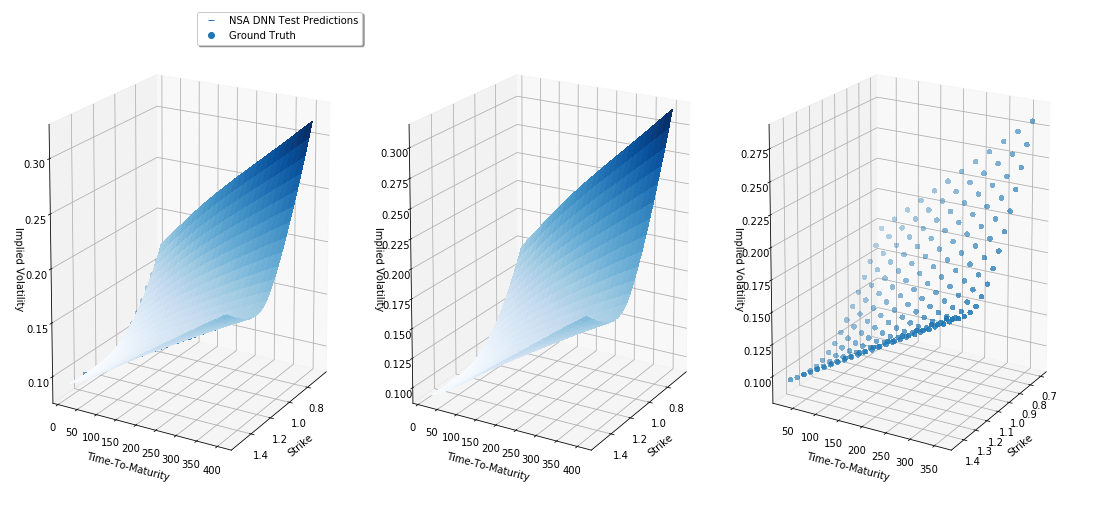

In [19]:
fig = Plt_1.plot_all_in_one(ind = 0, view_angle=(15, 30))


In [17]:
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

nsa_ivs_for_predictions = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes_test, ttms_test)

legend = ["NSA IVS for Ground Truth", "NSA IVS for Prediction", "Ground Truth Grid", "Predicted Grid"]

plot_data = {
    "iv_grid_1": data_nsa_train[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs[600-180:],
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "iv_surface_2": nsa_ivs_for_predictions,
    "stikes_surface_2": strikes_test,
    "ttms_surface_2": ttms_test,
    "legend": legend
}

Plt_2 = IV_Plotting_Helper(data=plot_data)

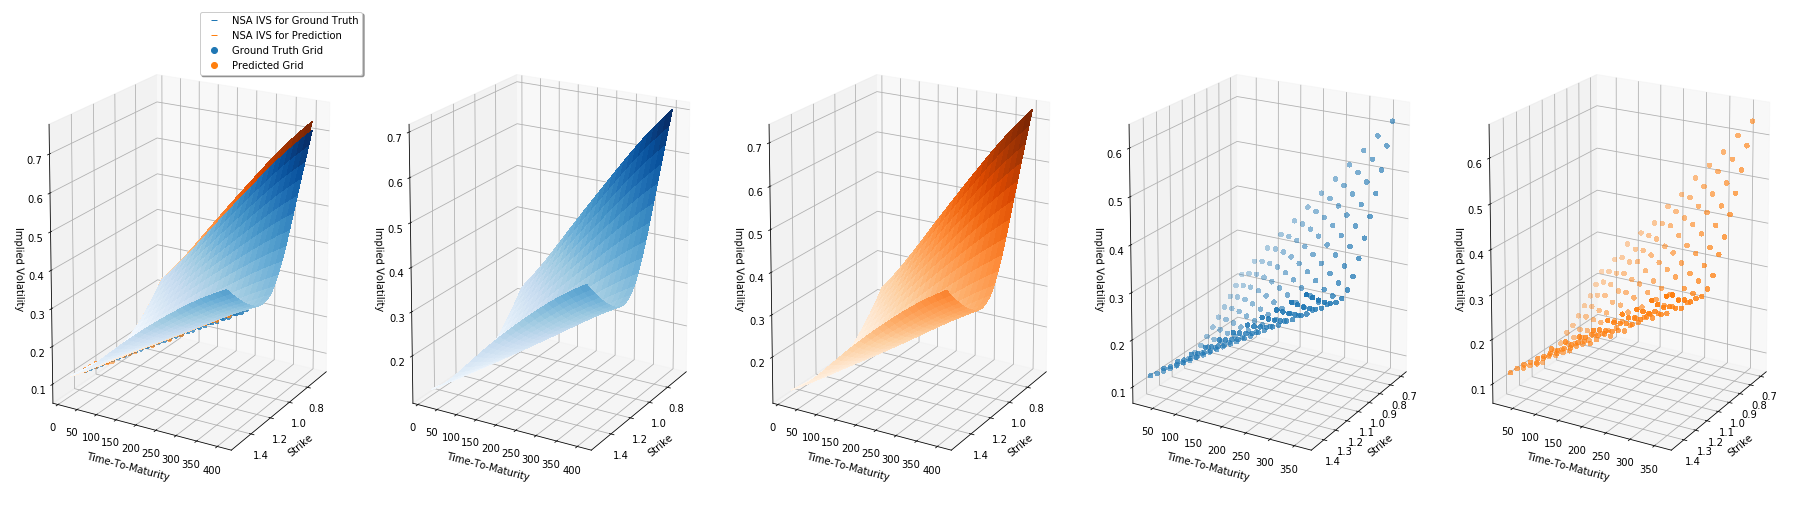

In [18]:
fig = Plt_2.plot_all_in_one(ind = 70, view_angle=(15, 30))
plt.savefig("nsda_iv_example.pdf")

Text(0.5, 0, 'Timestep')

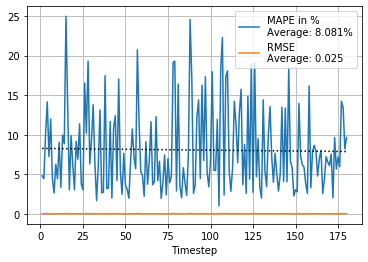

In [22]:
import matplotlib.pyplot as plt

true_ivs = iv_data[600-180:,:,:,0]
predicted_iv_surfaces = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes, ttms)

mape = np.mean(np.abs(true_ivs-predicted_iv_surfaces)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_iv_surfaces,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")

In [23]:
#Test for NSA Conditions for predicted implied vol surfaceses
ind = 1

violations = nsa_ivs.nsa_dnn.test_for_conditions(predicted_iv_surfaces[ind,:,:].flatten(), strikes_test, ttms_test)

print([i.numpy()[0] for i in violations])

[117977180000.0, 0.45549342, 23036984.0, 0.02864466]


In [40]:
# write more Transformer stuff 
# write more in sec 4.1 -- done
# call for all in windows no more feature 
# heigher weights for small prices/ivs
# train with more artificial data

In [14]:
a = np.array([[1,2,3]])
b = np.array([[1,2]])
np.multiply(a.T,b)

array([[1, 2],
       [2, 4],
       [3, 6]])

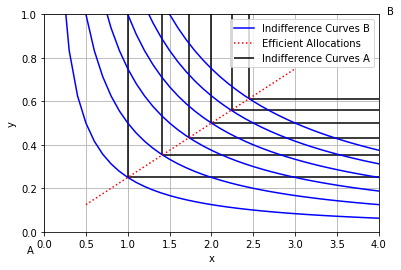

In [145]:
u_b = np.arange(0.5,3.5,0.5) 
u_a = [1,1.41,2,1.73,2.24,2.45]
x_a = np.arange(0,4,0.1)
y_a = np.arange(0,1,0.1)
#y_a = u_b / (8-2* x_a)
#u_a = min (x_a, 4_y_a)

#u_a = np.min(x_a, 4*y_a)
#u_b = 2 * x_b * y_b
#y_a = 1-u_b[0] / 2 / (4-x_a)
#plt.plot(x_a,y_a, c="b", label="Indifference Curves B")
y_b = u_b[0] / 2 / (4-x_a)
plt.plot(4-x_a,y_b, c="b", label="Indifference Curves B")
plt.vlines(u_a[0], ymin=u_a[0]/4, ymax=1, label="Indifference Curves A")
plt.hlines(u_a[0]/4, xmin=u_a[0], xmax=4)

for i in range(1, u_b.shape[0]):
    #y_a = 1-u_b[i] / 2 / (4-x_a)
    #plt.plot(x_a,y_a, c="b")
    y_b = u_b[i] / 2 / (4-x_a)
    plt.plot(4-x_a,y_b, c="b")

    plt.vlines(u_a[i], ymin=u_a[i]/4, ymax=1)
    plt.hlines(u_a[i]/4, xmin=u_a[i], xmax=4)

#plt.plot(2,.5, "*", c="red", label="Rawlsian Choice")
#plt.plot(0.01,0.01, "*", c="green",label="Utilitarian Choice")
plt.plot([0.5,3],[0.5/4,3/4], c="red", ls=":", label="Efficient Allocations")
plt.xlim(0,4)
plt.ylim(0,1)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.text(-0.2,-0.1,"A")
plt.text(4.1,1,"B")
plt.grid(True)


plt.savefig("boxlpox.pdf")

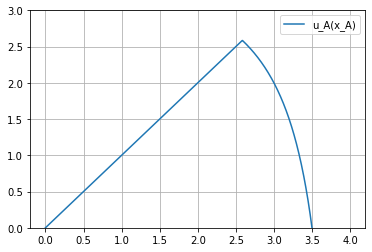

In [100]:
x = np.arange(0,4,0.004)
f = np.zeros(1000)

for i in range(1000):
    
    f[i] = min(x[i], 4- 2/(4-x[i]))

plt.plot(x,f, label="u_A(x_A)")
plt.ylim(0,3)
plt.grid(True)
plt.legend()
plt.savefig("tmptmptmp.pdf")

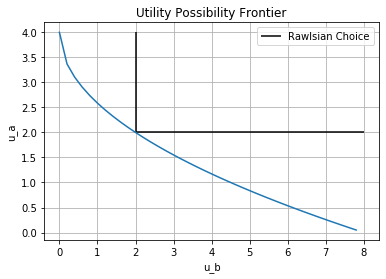

In [114]:
#u_a = 4 - \sqrt(2u_b)

u_b = np.arange(0,8,0.2)

u_a = 4 - np.sqrt(2*u_b)

#ub = u_b = 0.5 * (4-ua)**2

plt.plot(u_b,u_a)
plt.vlines(2, ymin=2, ymax=4, label="Rawlsian Choice")
plt.hlines(2, xmin=2, xmax=8)
plt.grid(True)
plt.xlabel("u_b")
plt.ylabel("u_a")
plt.legend()
plt.title("Utility Possibility Frontier")
plt.savefig("tmp123.pdf")